In [1]:
# import relevant packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as ss
import seaborn as sns

import torch
import torch_geometric
from torch_geometric.loader import DataLoader

# set figure parameters
sc.settings.set_figure_params(dpi=100)

## define helper functions

In [2]:
# define a function to gather positions
def get_pos(n_x, n_y):
    # create the hex lattice
    xs = np.array([np.arange(0, n_x) + 0.5 if idx % 2 == 0 else np.arange(0, n_x) for idx in range(n_y)])
    # derive the y-step given a distance of one
    y_step = np.sqrt(1**2+0.5**2)
    ys = np.array([[y_step * idy] * n_x for idy in range(n_y)])
    # define the positions
    pos = np.vstack([xs.flatten(), ys.flatten()]).T
    return pos

In [3]:
# define a function to derive the gex from the sphex
def calc_gex(sphex):
    """
    Calculates the gene expression matrix from the spherical
    """
    # setup the gex
    n_genes = sphex.shape[1]+1
    gex = torch.from_numpy(np.zeros((sphex.shape[0], n_genes)).astype('float32'))
    # compute the gex
    for idx in range(n_genes):
        if idx == n_genes-1:
            gex[:,idx] = torch.sin(sphex[:,idx-1])
        else:
            gex[:,idx] = torch.cos(sphex[:,idx])
        for idx_ in range(idx):
            gex[:,idx] *= torch.sin(sphex[:,idx_])
    return gex

In [4]:
from torch_geometric.nn import GCNConv
from sklearn.neighbors import kneighbors_graph
# define the number of neighbors (six for visium)
n_neighbors = 6
# define the simcomen class
class simcomen(torch.nn.Module):
    # define initialization function
    def __init__(self, input_dim, output_dim, n_neighbors, seed=0):
        super(simcomen, self).__init__()
        # define the seed
        torch.manual_seed(seed)
        # set up the graph convolution
        self.conv1 = GCNConv(input_dim, output_dim, add_self_loops=False)
        # set up the linear layer for intracellular gene regulation
        self.lin = torch.nn.Linear(input_dim, output_dim)
        # define the neighbors
        self.n_neighbors = n_neighbors
        # define a tracking variable for the gene expression x matrix
        self.sphex = None
        self.gex = None

    # define a function to artificially set the g2g matrix
    def set_g2g(self, g2g):
        """
        Artifically sets the core g2g matrix to be a specified interaction matrix
        """
        # set the weight as the input
        self.conv1.lin.weight = torch.nn.Parameter(g2g, requires_grad=False)
        # and then set the bias as all zeros
        self.conv1.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(n_genes).astype('float32')), requires_grad=False)

    # define a function to artificially set the g2g matrix
    def set_g2g_intra(self, g2g_intra):
        """
        Artifically sets the core g2g intracellular matrix to be a specified matrix
        """
        # set the weight as the input
        self.lin.weight = torch.nn.Parameter(g2g_intra, requires_grad=False)
        # and then set the bias as all zeros
        self.lin.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g_intra)).astype('float32')), requires_grad=False)

    # define a function to artificially set the sphex matrix
    def set_sphex(self, sphex):
        """
        Artifically sets the current sphex matrix
        """
        self.sphex = torch.nn.Parameter(sphex, requires_grad=True)
        
    # define the forward pass
    def forward(self, edge_index, batch):
        """
        Forward pass for prediction or training,
        convolutes the input by the expected interactions and returns log(Z_mft)
        """
        # compute the gex
        self.gex = calc_gex(self.sphex)
        # compute the message
        msg = self.conv1(self.gex, edge_index)
        # compute intracellular message
        msg_intra = self.lin(self.gex)
        # compute the log z mft
        log_z_mft = self.log_Z_mft(edge_index, batch)
        return msg, msg_intra, log_z_mft

    # define approximation function
    def log_Z_mft(self, edge_index, batch):
        """
        Mean Field Theory approximation to the partition function. Assumptions used are:
        - expression of values of genes are close to their mean values over the visium slide
        - \sum_b g_{a,b} m^b >0 \forall a, where m is the mean gene expression and g is the gene-gene
          interaction matrix.
        """
        # retrieve number of spots
        num_spots = self.gex.shape[0]
        # calculate mean gene expression        
        mean_genes = torch.mean(self.gex, axis=0).reshape(-1,1)  # the mean should be per connected graph
        # calculate the norm of the sum of mean genes
        g = torch.norm(torch.mm( self.n_neighbors*self.conv1.lin.weight + 2*self.lin.weight, mean_genes))   # maybe needs to change to g = torch.norm(torch.mm(mean_genes, self.conv1.lin.weight))
        # calculate the contribution for mean values        
        z_mean = - num_spots  * torch.mm(torch.mm(torch.t(mean_genes), self.lin.weight + 0.5 * self.n_neighbors * self.conv1.lin.weight),  mean_genes)
        # calculate the contribution gene interactions
        z_interaction = self.z_interaction(num_spots=num_spots, g=g)
        # add the two contributions        
        log_z_mft = z_mean + z_interaction
        return log_z_mft

    def z_interaction(self, num_spots, g):
        """
        Avoid exploding exponentials by returning an approximate interaction term for the partition function.
        """
        if g>20:
            z_interaction = num_spots * ( g - torch.log( g) )
        else:
            z_interaction = num_spots * torch.log((torch.exp( g) - torch.exp(- g))/( g))
        return z_interaction

In [5]:
# define the celcomen class
class celcomen(torch.nn.Module):
    # define initialization function
    def __init__(self, input_dim, output_dim, n_neighbors, seed=0):
        super(celcomen, self).__init__()
        # define the seed
        torch.manual_seed(seed)
        # set up the graph convolution
        self.conv1 = GCNConv(input_dim, output_dim, add_self_loops=False)
        # set up the linear layer for intracellular gene regulation
        self.lin = torch.nn.Linear(input_dim, output_dim)
        # define the neighbors
        self.n_neighbors = n_neighbors
        # define a tracking variable for the gene expression x matrix
        self.gex = None

    # define a function to artificially set the g2g matrix
    def set_g2g(self, g2g):
        """
        Artifically sets the core g2g matrix to be a specified interaction matrix
        """
        # set the weight as the input
        self.conv1.lin.weight = torch.nn.Parameter(g2g, requires_grad=True)
        # and then set the bias as all zeros
        self.conv1.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g)).astype('float32')), requires_grad=False)

    # define a function to artificially set the g2g matrix
    def set_g2g_intra(self, g2g_intra):
        """
        Artifically sets the core g2g intracellular matrix to be a specified matrix
        """
        # set the weight as the input
        self.lin.weight = torch.nn.Parameter(g2g_intra, requires_grad=True)
        # and then set the bias as all zeros
        self.lin.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g_intra)).astype('float32')), requires_grad=False)

    # define a function to artificially set the sphex matrix
    def set_gex(self, gex):
        """
        Artifically sets the current sphex matrix
        """
        self.gex = torch.nn.Parameter(gex, requires_grad=False)
        
    # define the forward pass
    def forward(self, edge_index, batch):
        """
        Forward pass for prediction or training,
        convolutes the input by the expected interactions and returns log(Z_mft)
        """
        # compute the message
        msg = self.conv1(self.gex, edge_index)
        # compute intracellular message
        msg_intra = self.lin(self.gex)
        # compute the log z mft
        log_z_mft = self.log_Z_mft(edge_index, batch)
        return msg, msg_intra, log_z_mft

    # define approximation function
    def log_Z_mft(self, edge_index, batch):
        """
        Mean Field Theory approximation to the partition function. Assumptions used are:
        - expression of values of genes are close to their mean values over the visium slide
        - \sum_b g_{a,b} m^b >0 \forall a, where m is the mean gene expression and g is the gene-gene
          interaction matrix.
        """
        # retrieve number of spots
        num_spots = self.gex.shape[0]
        # calculate mean gene expression        
        mean_genes = torch.mean(self.gex, axis=0).reshape(-1,1)  # the mean should be per connected graph
        # calculate the norm of the sum of mean genes
        g = torch.norm(torch.mm( self.n_neighbors*self.conv1.lin.weight + 2*self.lin.weight, mean_genes))   # maybe needs to change to g = torch.norm(torch.mm(mean_genes, self.conv1.lin.weight))
        # calculate the contribution for mean values        
        z_mean = - num_spots  * torch.mm(torch.mm(torch.t(mean_genes), self.lin.weight + 0.5 * self.n_neighbors * self.conv1.lin.weight),  mean_genes)
        # calculate the contribution gene interactions
        z_interaction = self.z_interaction(num_spots=num_spots, g=g)
        # add the two contributions        
        log_z_mft = z_mean + z_interaction
        return log_z_mft

    def z_interaction(self, num_spots, g):
        """
        Avoid exploding exponentials by returning an approximate interaction term for the partition function.
        """
        if g>20:
            z_interaction = num_spots * ( g - torch.log( g) )
        else:
            z_interaction = num_spots * torch.log((torch.exp( g) - torch.exp(- g))/( g))
        return z_interaction

In [6]:
# define a function to normalize the g2g
def normalize_g2g(g2g):
    """
    Addresses any small fluctuations in symmetrical weights
    """
    # symmetrize the values
    g2g = (g2g + g2g.T) / 2
    # force them to be between 0-1
    g2g[g2g < 0] = 0
    g2g[g2g > 1] = 1
    # force the central line to be 1
    for idx in range(len(g2g)):
        g2g[idx, idx] = 1
    return g2g

## read in perturb-map data

In [7]:
# read in data
prefix = 'GSM5808054_KP_1'
a = sc.read_visium(f'/home/dchen2/LITERATURE/GSE193460_RAW/{prefix}')
a.var_names_make_unique()
# remove off tissue spots
off_tissue = pd.read_csv(f'/home/dchen2/LITERATURE/GSE193460_RAW/{prefix}/off_tissue.csv.gz', index_col=0)
a = a[~a.obs.index.isin(off_tissue.index)]
# load in spot annotations
spot_anno = pd.read_csv(f'/home/dchen2/LITERATURE/GSE193460_RAW/{prefix}/spot_annotation.csv.gz', index_col=0)
a.obs = spot_anno

/home/dchen2/anaconda3/envs/base_py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/dchen2/anaconda3/envs/base_py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


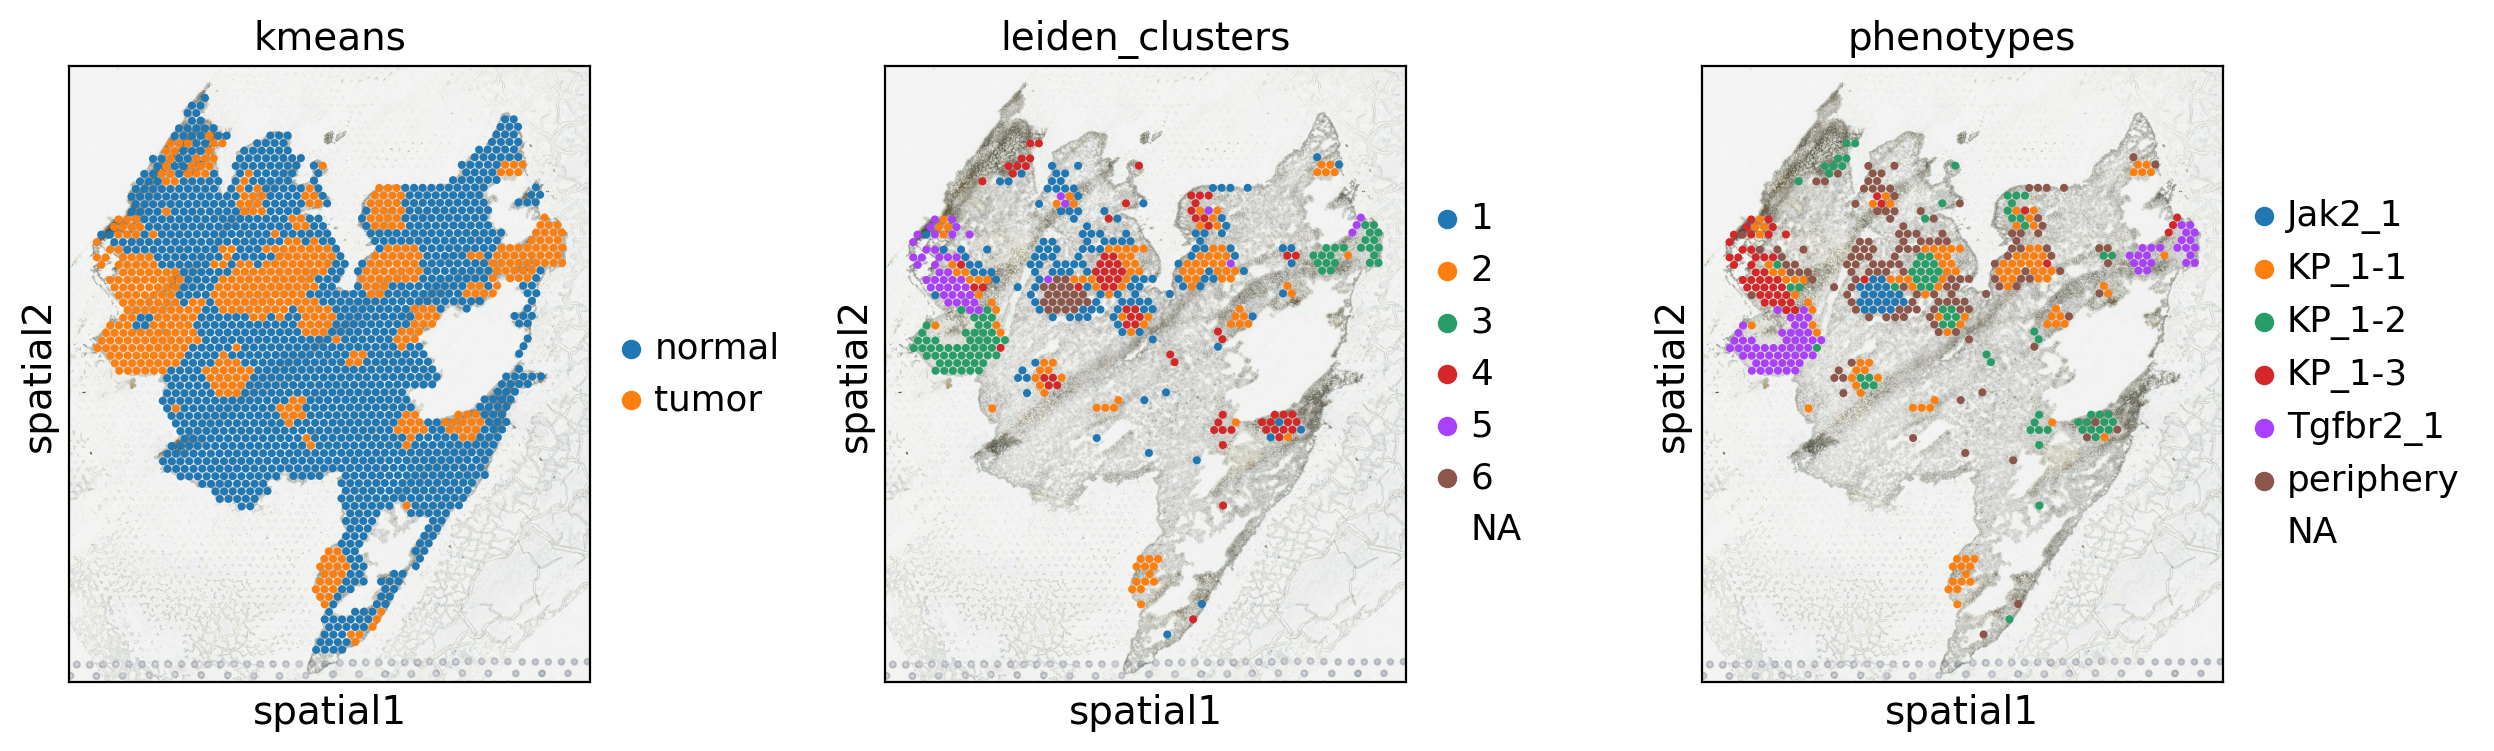

In [8]:
# confirm annotations were successfully transferred over
a.obs['leiden_clusters'] = a.obs['leiden_clusters'].dropna().astype(int).astype(str)
sc.pl.spatial(a, color=['kmeans','leiden_clusters','phenotypes'], s=10)

In [9]:
from scipy.spatial.distance import squareform, pdist
# retrieve the space
idxs = a.obs['leiden_clusters'].dropna().index
coords = a[idxs].obsm['spatial']
coords_dist = pd.DataFrame(squareform(pdist(coords)), index=idxs, columns=idxs)

(array([ 478.,    0., 1828.,    0., 2436.,  500., 2420., 1094., 2358.,
        1346.]),
 array([  0.        ,  19.98224212,  39.96448423,  59.94672635,
         79.92896847,  99.91121058, 119.8934527 , 139.87569482,
        159.85793693, 179.84017905, 199.82242116]),
 <BarContainer object of 10 artists>)

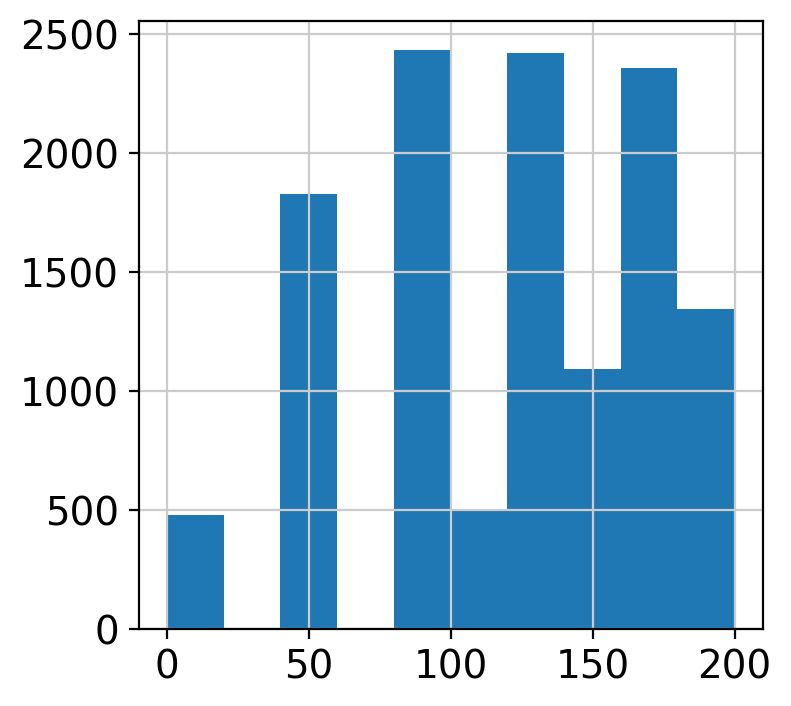

In [10]:
# histogram to confirm dual peaks at 0, 50, and 100
plt.hist(coords_dist.values.flatten()[coords_dist.values.flatten() < 200])

## define lesions

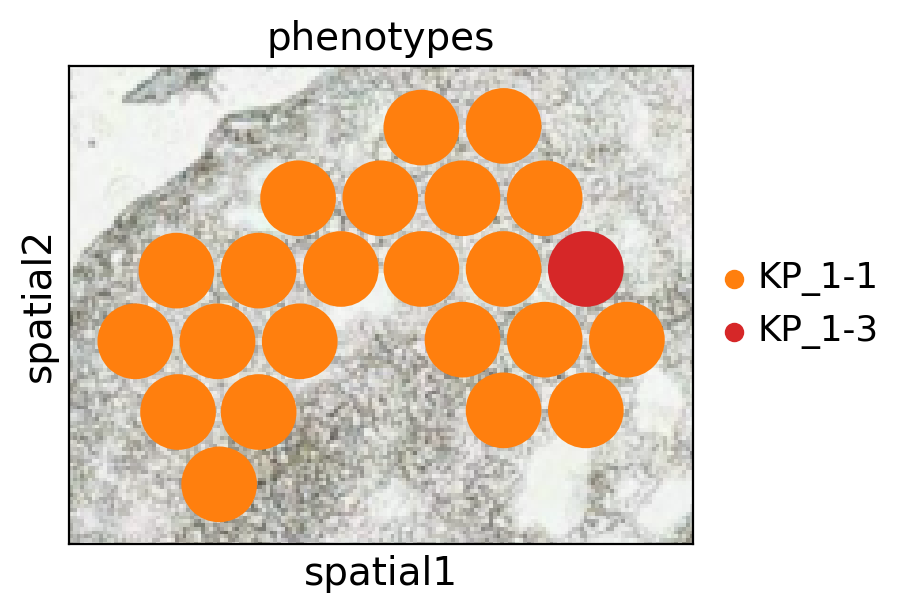

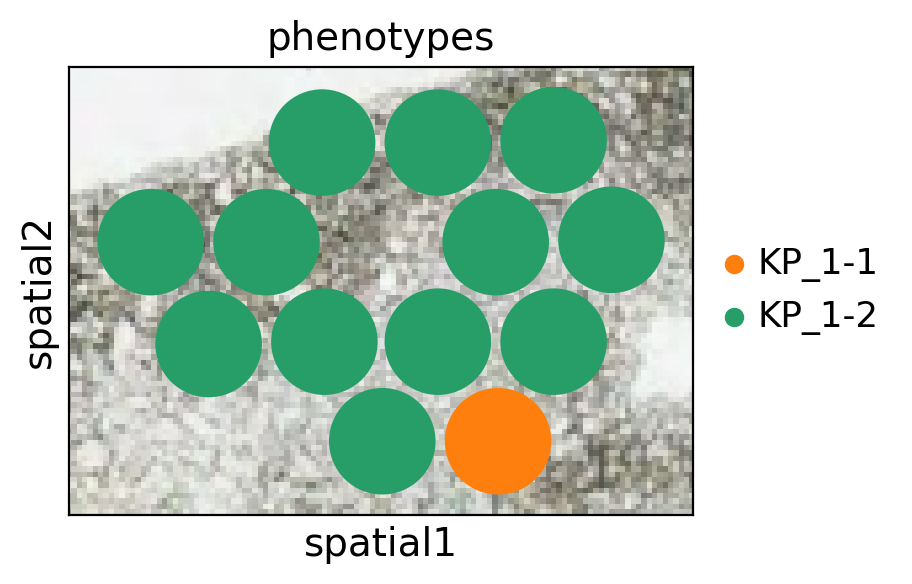

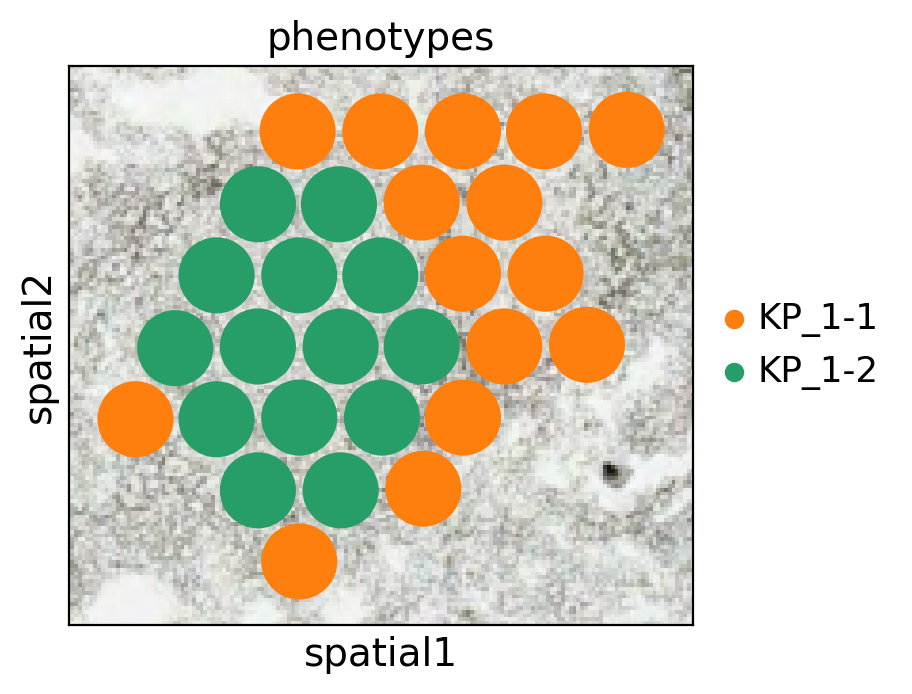

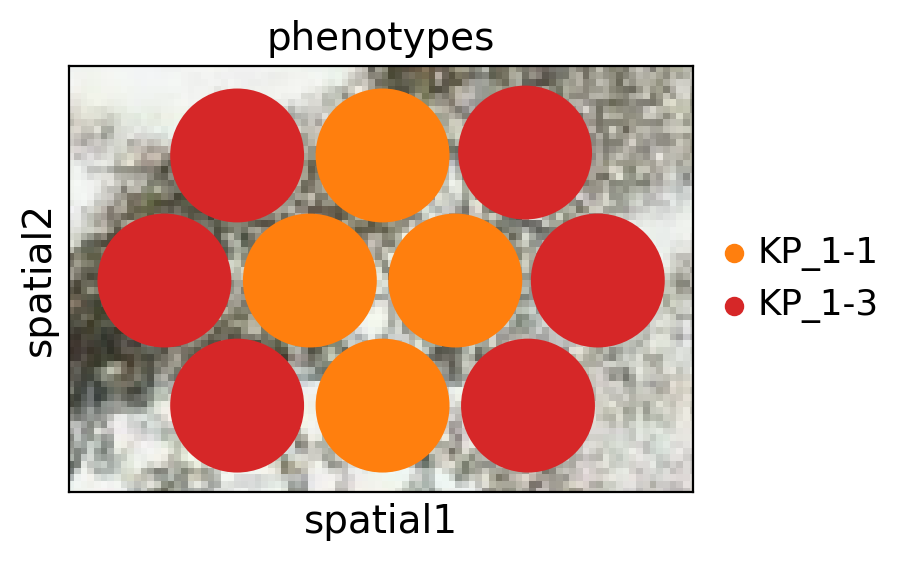

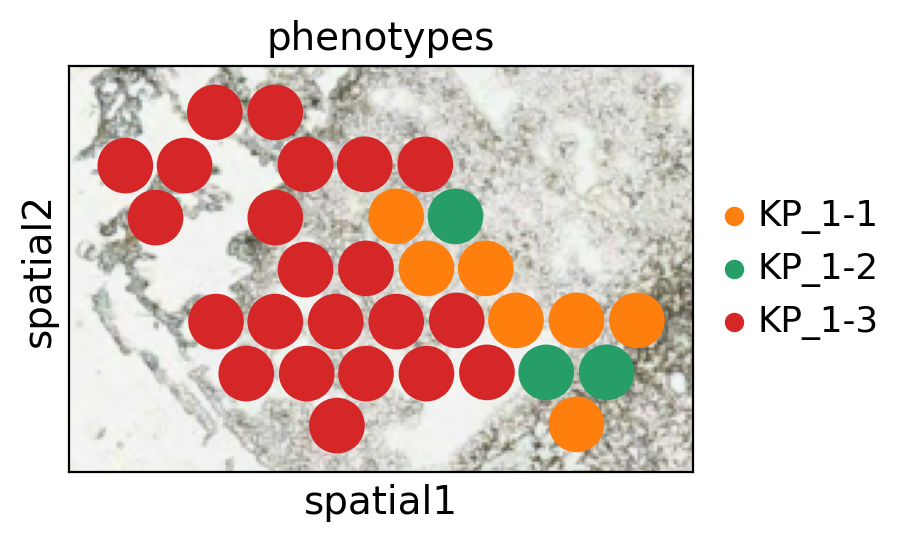

In [11]:
# retrieve the indexes of the perturbed
idxs_perturbed = a.obs.index[a.obs['phenotypes'].str.startswith('Jak2') | a.obs['phenotypes'].str.startswith('Tgfbr2')]
# derive the subsets
mask1 = (a.obsm['spatial'][:, 0] > 2100) & (a.obsm['spatial'][:, 0] < 2900) & \
(a.obsm['spatial'][:, 1] > 1500) & (a.obsm['spatial'][:, 1] < 1900) & \
(a.obs['phenotypes'].str.startswith('KP_')) & (a.obs.index.isin(coords_dist.index[(coords_dist[idxs_perturbed] > 100).all(1)]))
sc.pl.spatial(a[mask1], color=['phenotypes'], s=10)
mask2 = (a.obsm['spatial'][:, 0] > 2700) & (a.obsm['spatial'][:, 0] < 3000) & \
(a.obsm['spatial'][:, 1] > 2500) & (a.obsm['spatial'][:, 1] < 3000) & \
(a.obs['phenotypes'].str.startswith('KP_')) & (a.obs.index.isin(coords_dist.index[(coords_dist[idxs_perturbed] > 100).all(1)]))
sc.pl.spatial(a[mask2], color=['phenotypes'], s=10)
mask3 = (a.obsm['spatial'][:, 0] > 1600) & (a.obsm['spatial'][:, 0] < 2100) & \
(a.obsm['spatial'][:, 1] > 1500) & (a.obsm['spatial'][:, 1] < 1900) & \
(a.obs['phenotypes'].str.startswith('KP_')) & (a.obs.index.isin(coords_dist.index[(coords_dist[idxs_perturbed] > 100).all(1)]))
sc.pl.spatial(a[mask3], color=['phenotypes'], s=10)
mask4 = (a.obsm['spatial'][:, 0] > 800) & (a.obsm['spatial'][:, 0] < 1050) & \
(a.obsm['spatial'][:, 1] > 1400) & (a.obsm['spatial'][:, 1] < 1550) & \
(a.obs['phenotypes'].str.startswith('KP_')) & (a.obs.index.isin(coords_dist.index[(coords_dist[idxs_perturbed] > 100).all(1)]))
sc.pl.spatial(a[mask4], color=['phenotypes'], s=10)
mask5 = (a.obsm['spatial'][:, 0] > 500) & (a.obsm['spatial'][:, 0] < 1400) & \
(a.obsm['spatial'][:, 1] > 1560) & (a.obsm['spatial'][:, 1] < 2500) & \
(a.obs['phenotypes'].str.startswith('KP_')) & (a.obs.index.isin(coords_dist.index[(coords_dist[idxs_perturbed] > 100).all(1)]))
sc.pl.spatial(a[mask5], color=['phenotypes'], s=10)
# subset for these representative subgraphs
a1 = a[mask1].copy()
a2 = a[mask2].copy()
a3 = a[mask3].copy()
a4 = a[mask4].copy()
a5 = a[mask5].copy()

## retrieve highly variable genes

In [12]:
# derive highly variable genes for all of these and ensure that TGFBR2 is included
a_objs = {'a1':a1, 'a2':a2, 'a3':a3, 'a4':a4, 'a5':a5}
hvgs = []
for name, a_obj in a_objs.items():
    # extract irrelevant columns
    cols = ['WPRE', 'mCherry_Nter', 'linker', 'Procode']
    a_obj.obs[cols] = sc.get.obs_df(a_obj, keys=cols)
    a_obj = a_obj[:, ~a_obj.var.index.isin(cols)].copy()
    # normalize the data
    sc.pp.normalize_total(a_obj, target_sum=1e6)
    sc.pp.log1p(a_obj)
    # derive highly variable genes
    sc.pp.highly_variable_genes(a_obj, flavor='seurat', min_mean=0.5, max_mean=7.5, min_disp=0.5)
    print(name, a_obj.var['highly_variable'].sum(), a_obj.var.loc['Tgfbr2', 'highly_variable'], a_obj.var.loc['Jak2', 'highly_variable'])
    hvgs.extend(a_obj.var.index[a_obj.var['highly_variable']])
    a_objs[name] = a_obj

a1 4093 True False
a2 3660 False False
a3 3864 False False
a4 3820 False False
a5 4003 False False


/home/dchen2/anaconda3/envs/base_py39/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:247: RuntimeWarning: invalid value encountered in divide
  df["dispersions_norm"] = (


In [13]:
# find common highly variable genes (need to be in at least 75% of samples)
hvg_list = pd.Series(hvgs).value_counts()
hvg_list = hvg_list.index[hvg_list >= (len(a_objs) * 0.75)].tolist()
len(hvg_list), 'Tgfbr2' in hvg_list

(377, False)

In [14]:
# add TGFBR2 and JAK2 to the list
hvg_list.extend(['Tgfbr2'])

In [15]:
# create a gene subset for testing
genes = hvg_list
# create a tracking variable of the datas for the dataloader
data_list = []
# loop through each sample
for name, a_obj in a_objs.items():
    # retrieve positions from the data
    pos = torch.from_numpy(a_obj.obsm['spatial'])
    # convert the gene expression data to numpy
    x = torch.from_numpy(a_obj[:, genes].X.todense())
    # sphere normalize the data (just in case)
    norm_factor = torch.pow(x, 2).sum(1).reshape(-1,1)
    assert (norm_factor > 0).all()
    x = torch.div(x, norm_factor)
    y = torch.Tensor([0])  # here we will store GT value
    # find the edges via kneighbors, not including self because we are considering intercellular
    edge_index = kneighbors_graph(pos, n_neighbors, include_self=False).todense()
    edge_index = torch.from_numpy(np.array(np.where(edge_index)))
    # create the final torch geometric graph dataframe
    data = torch_geometric.data.Data(x=x, pos=pos, y=y, edge_index=edge_index)
    data.validate(raise_on_error=True)  # performs basic checks on the graph
    # store the data in the data list tracker
    data_list.append(data)
    print(data)
# convert into a data loader
data_loader = DataLoader(data_list, batch_size=1, shuffle=True)

Data(x=[23, 378], edge_index=[2, 138], y=[1], pos=[23, 2])
Data(x=[13, 378], edge_index=[2, 78], y=[1], pos=[13, 2])
Data(x=[29, 378], edge_index=[2, 174], y=[1], pos=[29, 2])
Data(x=[10, 378], edge_index=[2, 60], y=[1], pos=[10, 2])
Data(x=[32, 378], edge_index=[2, 192], y=[1], pos=[32, 2])


## learn wild type gene-gene links

In [16]:
# define the parameters of the model
n_genes = len(genes)
learning_rate = 1e0
zmft_scalar = 1e-1
seed = 0
epochs = 100
# instantiate the model, input and output will be the same
model_rev = celcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
# now perform the simulation
np.random.seed(seed)
# artifically set the g2g matrix
input_g2g = np.random.uniform(size=(n_genes, n_genes)).astype('float32')
input_g2g = normalize_g2g((input_g2g + input_g2g.T) / 2)
model_rev.set_g2g(torch.from_numpy(input_g2g))
model_rev.set_g2g_intra(torch.from_numpy(input_g2g))
# initialize a gene expression matrix
model_rev.set_gex(x)

In [17]:
from tqdm import tqdm
# setup the initial optimizer
optimizer = torch.optim.SGD(model_rev.parameters(), lr=learning_rate, momentum=0)
# keep track of the losses per data object
loss, losses = None, []
# train the model
model_rev.train()
# work through epochs
for epoch in tqdm(range(epochs), total=epochs):
    # loop thorugh each data object
    losses_ = []
    for data in data_loader:
        # set the appropriate gex
        model_rev.set_gex(data.x)
        # derive the message as well as the mean field approximation
        msg, msg_intra, log_z_mft = model_rev(data.edge_index, 1)
        # compute the loss and track it
        loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model_rev.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model_rev.gex))) )
        losses_.append(loss.detach().numpy()[0][0])
        # derive the gradients, update, and clear
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # repeatedly force a normalization
        model_rev.conv1.lin.weight = torch.nn.Parameter(normalize_g2g(model_rev.conv1.lin.weight), requires_grad=True)
        model_rev.lin.weight = torch.nn.Parameter(normalize_g2g(model_rev.lin.weight), requires_grad=True)
        optimizer = torch.optim.SGD(model_rev.parameters(), lr=learning_rate, momentum=0)
    # now take the average loss of the objects
    losses.append(np.mean(losses_))

100%|█████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


[Text(0.5, 0, 'epochs'), Text(0, 0.5, 'loss')]

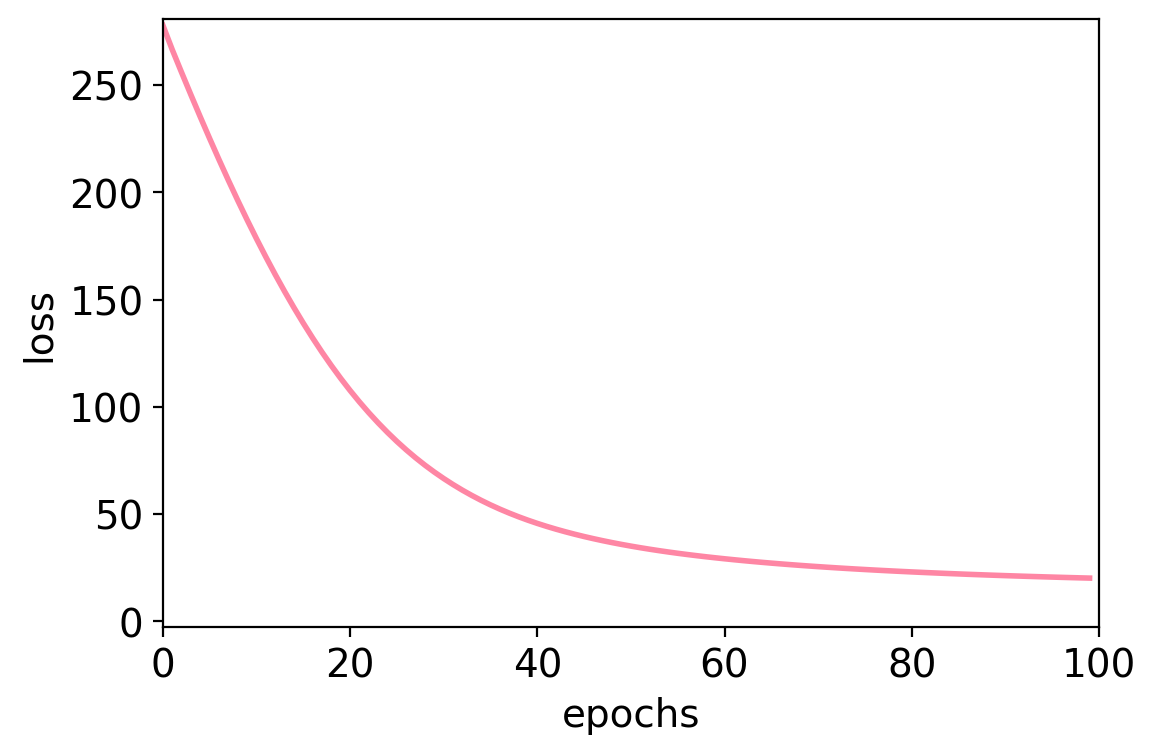

In [18]:
# create the plot
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses, lw=2, color='#fe86a4')
ax.set_xlim(0, epochs)
vmin, vmax = min(min(losses), 0), max(losses)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')

## perturb the lesions based on learned links

In [19]:
# define a function to derive the gex from the sphex
def calc_gex(sphex):
    """
    Calculates the gene expression matrix from the spherical
    """
    # setup the gex
    n_genes = sphex.shape[1]+1
    gex = torch.from_numpy(np.zeros((sphex.shape[0], n_genes)).astype('float32'))
    # compute the gex
    for idx in range(n_genes):
        if idx == n_genes-1:
            gex[:,idx] = torch.sin(sphex[:,idx-1])
        else:
            gex[:,idx] = torch.cos(sphex[:,idx])
        for idx_ in range(idx):
            gex[:,idx] *= torch.sin(sphex[:,idx_])
    return torch.nan_to_num(gex)

In [20]:
# define a function to derive the gex from the sphex
def calc_sphex(gex):
    """
    Calculates the spherical expression matrix from the normal
    """
    # setup the gex
    n_sgenes = gex.shape[1]-1
    sphex = torch.from_numpy(np.zeros((gex.shape[0], n_sgenes)).astype('float32'))
    # compute the gex
    for idx in tqdm(range(n_sgenes), total=n_sgenes):
        sphex[:,idx] = gex[:,idx]
        for idx_ in range(idx):
            sphex[:,idx] /= torch.sin(sphex[:,idx_])
        sphex[:,idx] = torch.arccos(sphex[:,idx])
    return sphex

In [21]:
# define the celcomen class
class simcomen(torch.nn.Module):
    # define initialization function
    def __init__(self, input_dim, output_dim, n_neighbors, seed=0):
        super(simcomen, self).__init__()
        # define the seed
        torch.manual_seed(seed)
        # set up the graph convolution
        self.conv1 = GCNConv(input_dim, output_dim, add_self_loops=False)
        # set up the linear layer for intracellular gene regulation
        self.lin = torch.nn.Linear(input_dim, output_dim)
        # define the neighbors
        self.n_neighbors = n_neighbors
        # define a tracking variable for the gene expression x matrix
        self.sphex = None
        self.gex = None

    # define a function to artificially set the g2g matrix
    def set_g2g(self, g2g):
        """
        Artifically sets the core g2g matrix to be a specified interaction matrix
        """
        # set the weight as the input
        self.conv1.lin.weight = torch.nn.Parameter(g2g, requires_grad=False)
        # and then set the bias as all zeros
        self.conv1.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(n_genes).astype('float32')), requires_grad=False)

    # define a function to artificially set the g2g matrix
    def set_g2g_intra(self, g2g_intra):
        """
        Artifically sets the core g2g intracellular matrix to be a specified matrix
        """
        # set the weight as the input
        self.lin.weight = torch.nn.Parameter(g2g_intra, requires_grad=False)
        # and then set the bias as all zeros
        self.lin.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g_intra)).astype('float32')), requires_grad=False)

    # define a function to artificially set the sphex matrix
    def set_sphex(self, sphex):
        """
        Artifically sets the current sphex matrix
        """
        self.sphex = torch.nn.Parameter(sphex, requires_grad=True)
        
    # define the forward pass
    def forward(self, edge_index, batch):
        """
        Forward pass for prediction or training,
        convolutes the input by the expected interactions and returns log(Z_mft)
        """
        # compute the gex
        self.gex = calc_gex(self.sphex)
        # compute the message
        msg = self.conv1(self.gex, edge_index)
        # compute intracellular message
        msg_intra = self.lin(self.gex)
        # compute the log z mft
        log_z_mft = self.log_Z_mft(edge_index, batch)
        return msg, msg_intra, log_z_mft

    # define approximation function
    def log_Z_mft(self, edge_index, batch):
        """
        Mean Field Theory approximation to the partition function. Assumptions used are:
        - expression of values of genes are close to their mean values over the visium slide
        - \sum_b g_{a,b} m^b >0 \forall a, where m is the mean gene expression and g is the gene-gene
          interaction matrix.
        """
        # retrieve number of spots
        num_spots = self.gex.shape[0]
        # calculate mean gene expression        
        mean_genes = torch.mean(self.gex, axis=0).reshape(-1,1)  # the mean should be per connected graph
        # calculate the norm of the sum of mean genes
        g = torch.norm(torch.mm( self.n_neighbors*self.conv1.lin.weight + 2*self.lin.weight, mean_genes))   # maybe needs to change to g = torch.norm(torch.mm(mean_genes, self.conv1.lin.weight))
        # calculate the contribution for mean values        
        z_mean = - num_spots  * torch.mm(torch.mm(torch.t(mean_genes), self.lin.weight + 0.5 * self.n_neighbors * self.conv1.lin.weight),  mean_genes)
        # calculate the contribution gene interactions
        z_interaction = self.z_interaction(num_spots=num_spots, g=g)
        # add the two contributions        
        log_z_mft = z_mean + z_interaction
        return log_z_mft

    def z_interaction(self, num_spots, g):
        """
        Avoid exploding exponentials by returning an approximate interaction term for the partition function.
        """
        if g>20:
            z_interaction = num_spots * ( g - torch.log( g) )
        else:
            z_interaction = num_spots * torch.log((torch.exp( g) - torch.exp(- g))/( g))
        return z_interaction

In [22]:
# report the current Tgfbr2 and Jak2 expression for each of our lung pieces
for name, a_obj in a_objs.items():
    values = sc.get.obs_df(a_obj, keys=['Tgfbr2']).mean(0)
    values.name = name
    print(values)

Tgfbr2    4.942376
Name: a1, dtype: float32
Tgfbr2    4.51876
Name: a2, dtype: float32
Tgfbr2    4.932833
Name: a3, dtype: float32
Tgfbr2    5.365823
Name: a4, dtype: float32
Tgfbr2    4.619204
Name: a5, dtype: float32


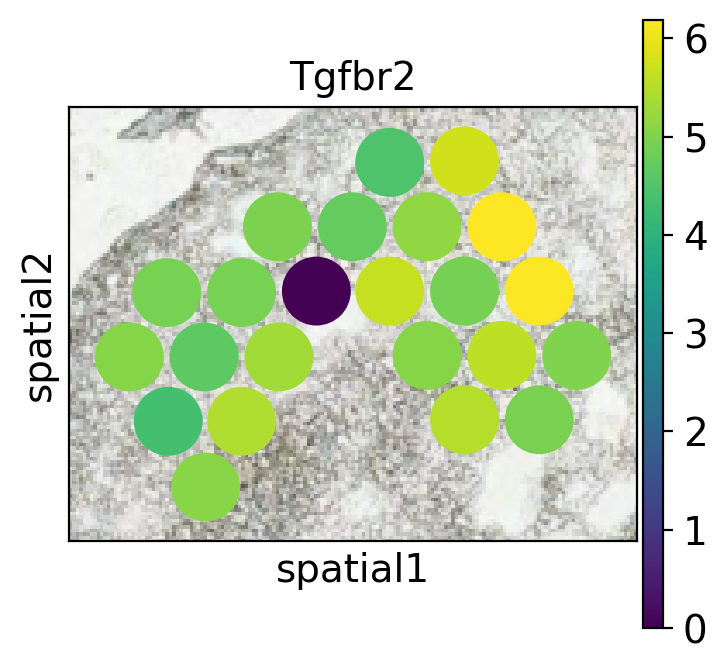

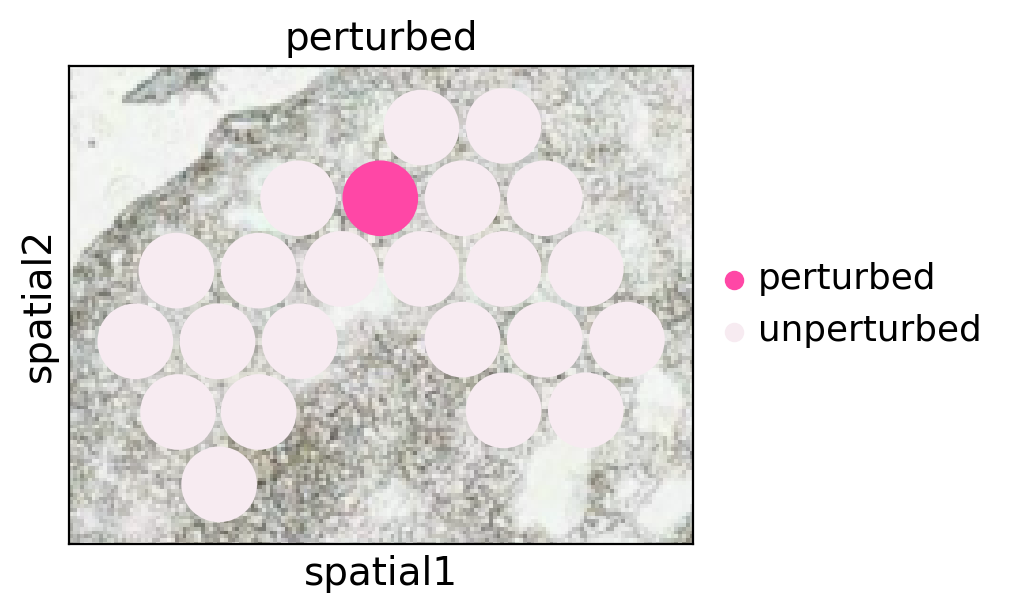

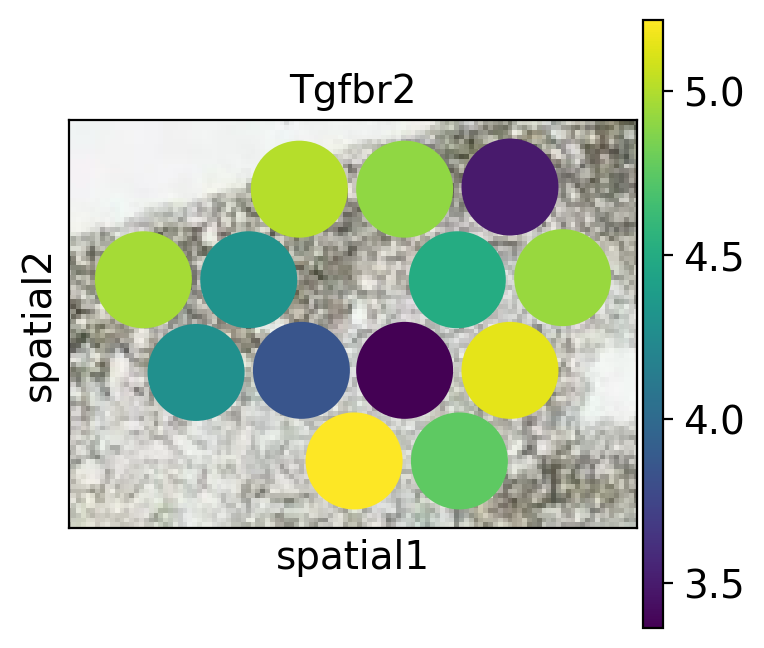

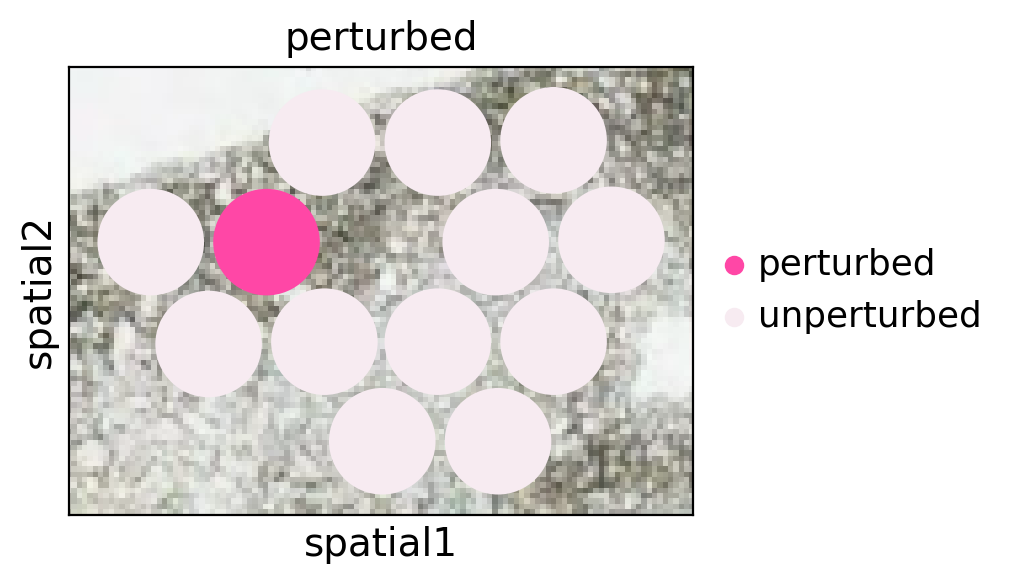

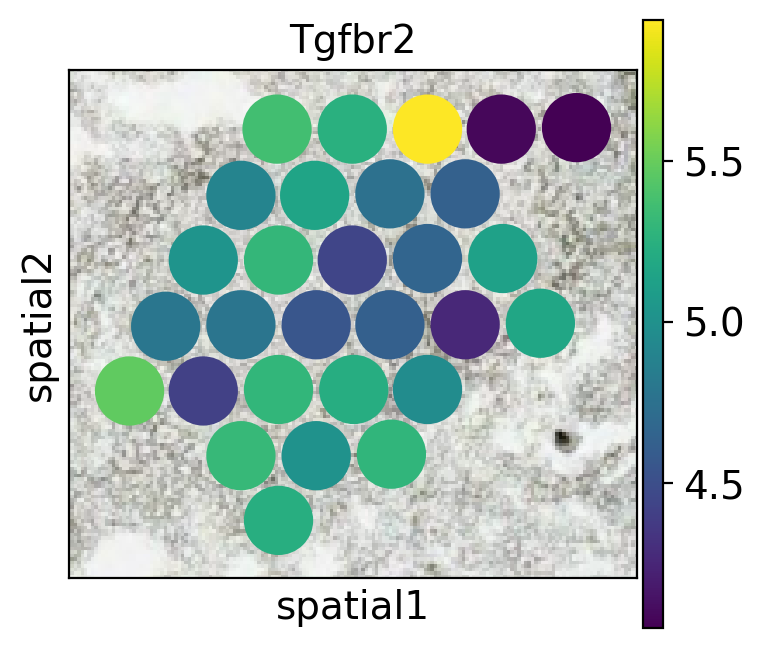

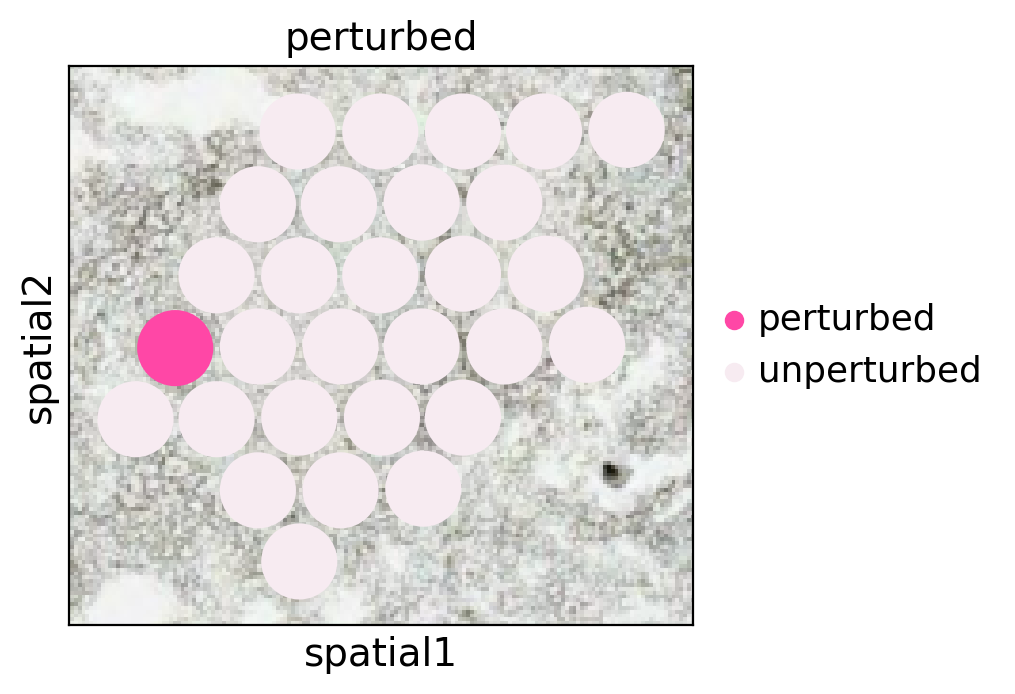

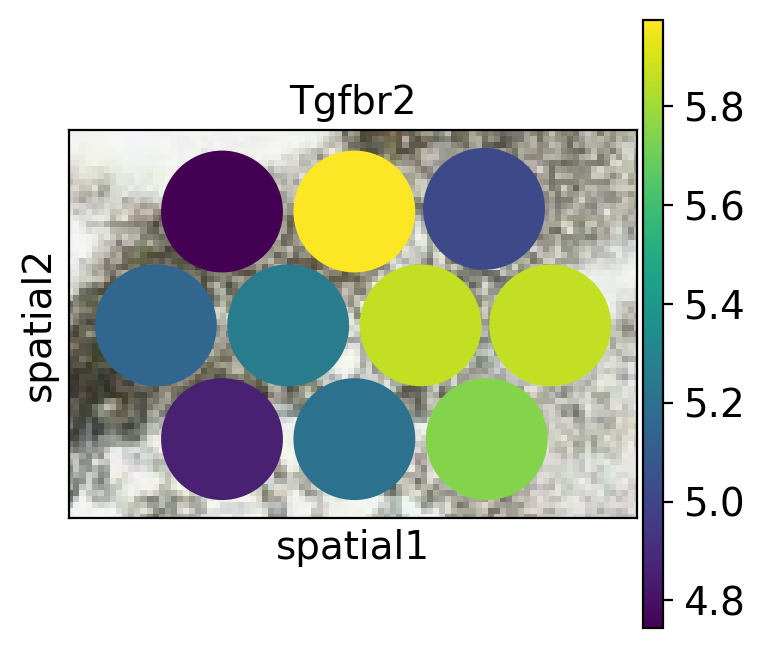

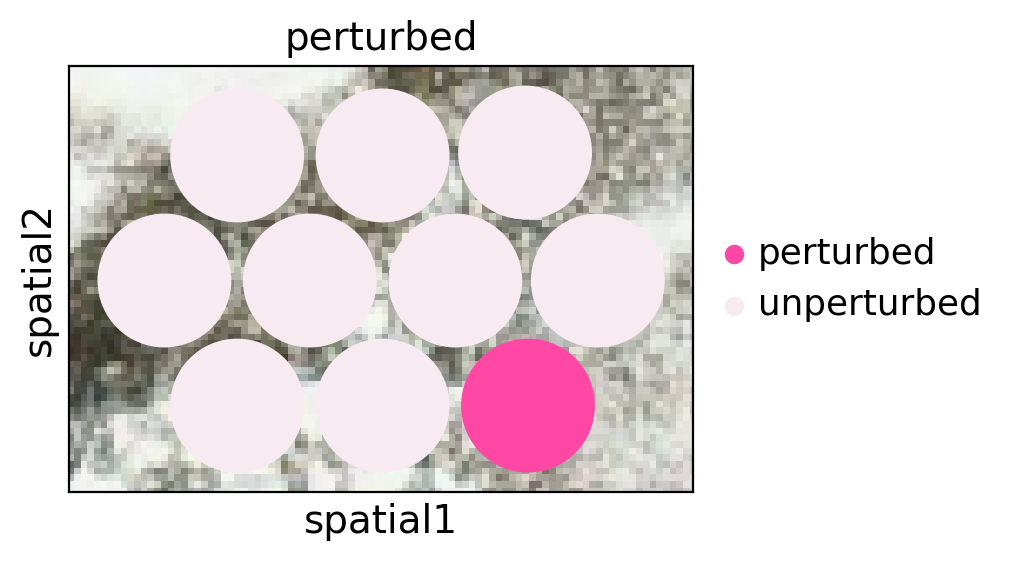

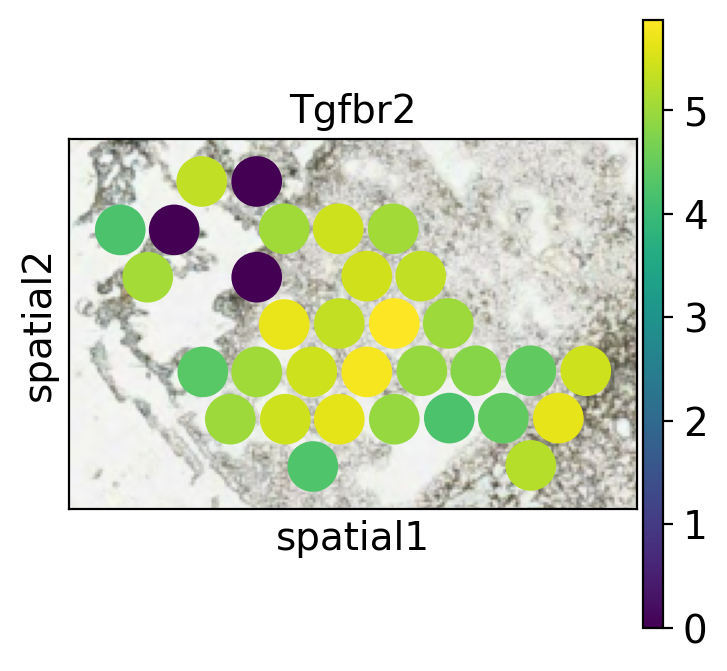

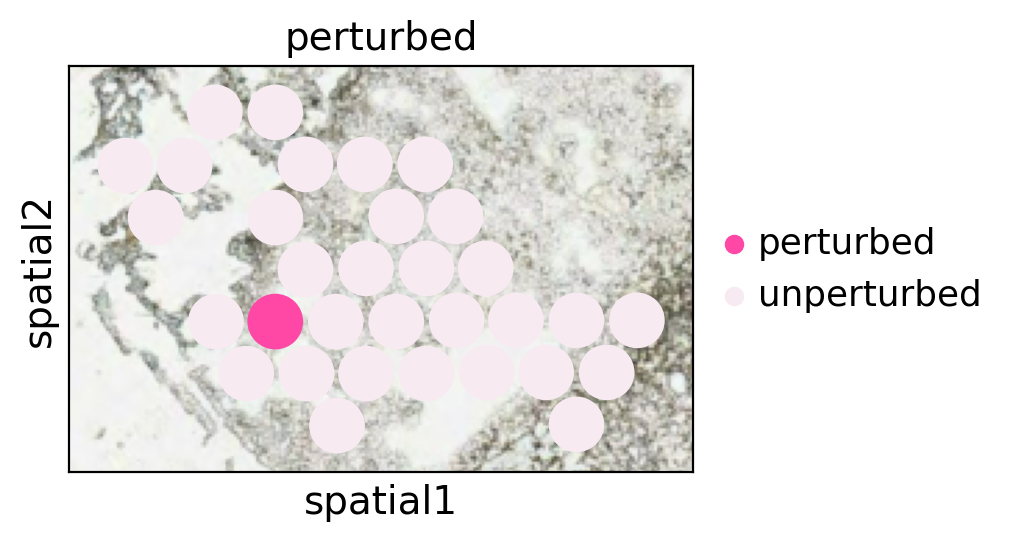

In [23]:
# create a copy of the objects to perform Tgfbr2 KO experiments
avis_subs = {k:v[:, genes].copy() for k,v in a_objs.items()}
for name, avis_sub in avis_subs.items():
    # retrieve the current values
    proposed_x = avis_sub.X.toarray().copy()
    sc.pl.spatial(avis_sub, color=['Tgfbr2'], use_raw=False, s=10)
    # adjust the X so we artificially introduce signaling to a random part of the tissue
    np.random.seed(0)
    df_gex = sc.get.obs_df(avis_sub, keys=['Tgfbr2'])['Tgfbr2']
    mask = avis_sub.obs.index == np.random.choice(avis_sub.obs.index[df_gex > 0], size=1)[0]
    idx = np.where(avis_sub.var_names == 'Tgfbr2')[0][0]
    proposed_x[mask, idx] = 0
    avis_sub.obs['perturbed'] = 'unperturbed'
    avis_sub.obs.loc[mask, 'perturbed'] = 'perturbed'
    avis_sub.uns['perturbed_colors'] = ['#ff47a6','#f7ebf1']
    sc.pl.spatial(avis_sub, color=['perturbed'], use_raw=False, s=10)
    avis_sub.X = proposed_x
    avis_subs[name] = avis_sub

## work through one example

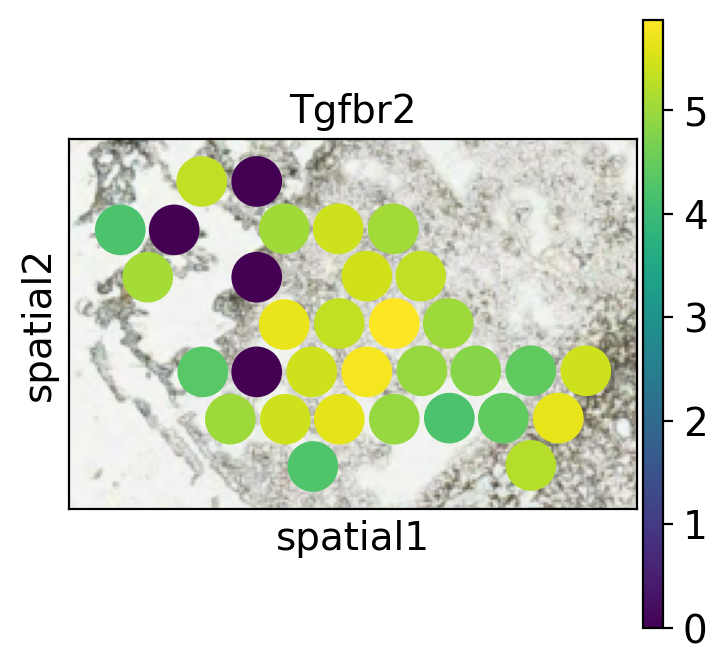

In [24]:
# provide an example
sc.pl.spatial(avis_sub, color=['Tgfbr2'], use_raw=False, s=10)

In [25]:
# define the parameters of the model
n_genes = avis_sub.shape[1]
learning_rate = 1e-3
zmft_scalar = 1e-1
seed = 0
epochs = 20

In [26]:
# retrieve positions from the data
pos = torch.from_numpy(avis_sub.obsm['spatial'])
edge_index = kneighbors_graph(pos, n_neighbors, include_self=False).todense()
edge_index = torch.from_numpy(np.array(np.where(edge_index)))

In [27]:
# instantiate the model, input and output will be the same
model = simcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
# now perform the simulation
np.random.seed(seed)
# convert the gene expression data to numpy
x = torch.from_numpy(avis_sub.X)
# sphere normalize the data (just in case)
norm_factor = torch.sqrt(torch.pow(x, 2).sum(1)).reshape(-1,1)
assert (norm_factor > 0).all()
x = torch.div(x, norm_factor)
# artifically set the g2g matrix
model.set_g2g(model_rev.conv1.lin.weight.clone().detach())
model.set_g2g_intra(model_rev.lin.weight.clone().detach())
# initialize a gene expression matrix
input_sphex = calc_sphex(x).clone().detach().numpy()
model.set_sphex(torch.from_numpy(input_sphex.astype('float32')))

100%|████████████████████████████████████████| 377/377 [00:01<00:00, 231.83it/s]


In [28]:
# set up the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
# keep track of the losses per data object
loss, losses = None, []
# train the model
model.train()
tmp_gexs = []
# work through epochs
for epoch in tqdm(range(epochs), total=epochs):
    # derive the message as well as the mean field approximation
    msg, msg_intra, log_z_mft = model(edge_index, 1)
    if (epoch % 5) == 0:
        tmp_gex = model.gex.clone().detach().numpy()
        tmp_gexs.append(tmp_gex)
    # compute the loss and track it
    loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
    losses.append(loss.detach().numpy()[0][0])
    # derive the gradients, update, and clear
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|███████████████████████████████████████████| 20/20 [04:39<00:00, 13.96s/it]


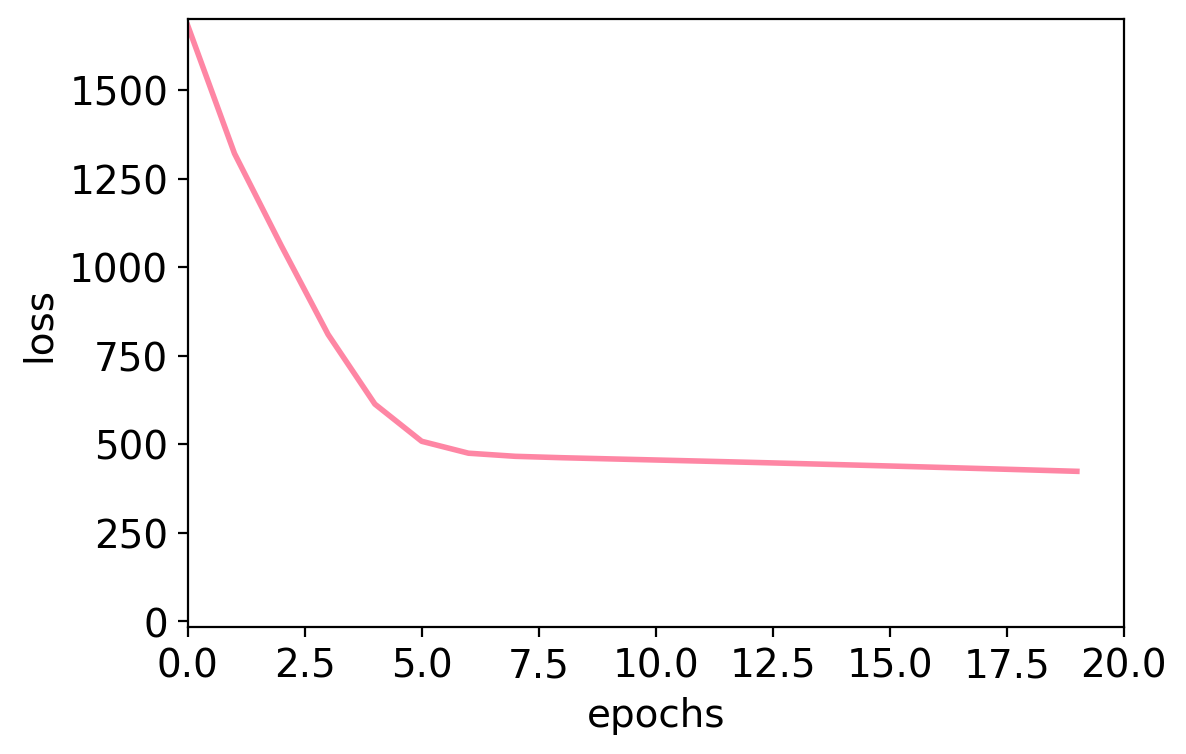

In [29]:
# plot the loss
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses, lw=2, color='#fe86a4')
ax.set_xlim(0, epochs)
vmin, vmax = min(min(losses), 0), max(losses)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')
# retrieve the data
output_gex = model.gex.detach().numpy()
output_msg = msg.detach().numpy()

In [30]:
# add the layers
for idx, tmp_gex in enumerate(tmp_gexs):
    avis_sub.layers[f'input{idx}'] = tmp_gex
avis_sub.layers['output'] = output_gex

In [31]:
# compute the differential within the area of interest vs outside
avis_sub.layers['diff'] = avis_sub.layers['output'] - avis_sub.layers['input0']
mask0 = avis_sub.obs['perturbed'] == 'unperturbed'
mask1 = avis_sub.obs['perturbed'] == 'perturbed'
diff_in_vs_out_p = pd.Series(avis_sub.layers['diff'][mask1].mean(0) - avis_sub.layers['diff'][mask0].mean(0),
                             index=avis_sub.var_names).sort_values()[::-1]
# remove the perturbed genes to get a clean look
perturbed_genes = ['Tgfbr2']
perturbed_label = 'Tgfbr2'
diff_in_vs_out_p = diff_in_vs_out_p.loc[~diff_in_vs_out_p.index.isin(perturbed_genes)]
diff_in_vs_out_p -= diff_in_vs_out_p.min()
diff_in_vs_out_p /= diff_in_vs_out_p.max()

# perform the differential with sphere normed data
# > WT
x = torch.from_numpy(avis_sub.copy().X)
norm_factor = torch.sqrt(torch.pow(x, 2).sum(1)).reshape(-1,1)
assert (norm_factor > 0).all()
x1 = torch.div(x, norm_factor)
# > TGFBR2 KO
x = torch.from_numpy(a[a.obs['phenotypes'].astype(str).str.startswith('Tgfbr2'), avis_sub.var.index].X.toarray())
norm_factor = torch.sqrt(torch.pow(x, 2).sum(1)).reshape(-1,1)
assert (norm_factor > 0).all()
x2 = torch.div(x, norm_factor)
diff_tgfbr2ko_vs_wt = pd.Series(x2.mean(0) - x1.mean(0), index=avis_sub.var.index)
diff_tgfbr2ko_vs_wt = diff_tgfbr2ko_vs_wt.loc[~diff_tgfbr2ko_vs_wt.index.isin(perturbed_genes)]

In [32]:
# compute the correlation
idxs = diff_in_vs_out_p.index.intersection(diff_tgfbr2ko_vs_wt.index)
print('Perturbed', ss.spearmanr(diff_in_vs_out_p.loc[idxs], diff_tgfbr2ko_vs_wt.loc[idxs]))

Perturbed SignificanceResult(statistic=0.4841870039962483, pvalue=1.4871585456734026e-23)


/loc/scratch/7949135/ipykernel_36721/3216810001.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Bin', y='Obs', data=df, saturation=1, linewidth=2,


(-1.0, 5.0)

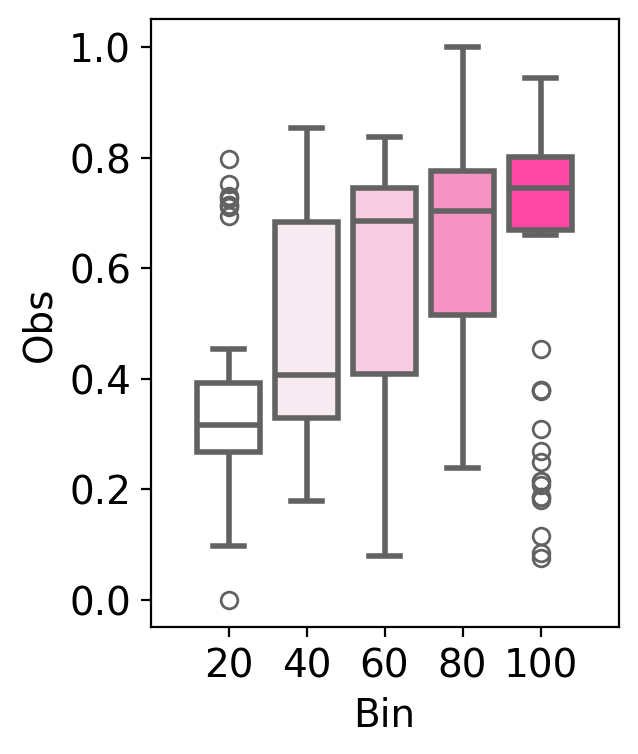

In [33]:
# setup the dataframe on percentile basis
idxs = diff_in_vs_out_p.index.intersection(diff_tgfbr2ko_vs_wt.index)
df = pd.concat([diff_in_vs_out_p.loc[idxs], diff_tgfbr2ko_vs_wt.loc[idxs]], axis=1)
df.columns = ['Obs','Exp']
df['Bin'] = np.nan
# derive the bins
vmin = min(diff_tgfbr2ko_vs_wt.loc[idxs])
step_size = 20
for step in range(100//step_size):
    vmax = np.percentile(df['Exp'], (step+1)*step_size)
    mask = (df['Exp'] >= vmin) & (df['Exp'] < vmax)
    vmin = vmax
    genes = df['Exp'].index[mask]
    df.loc[genes, 'Bin'] = str(int((step+1)*step_size))
# plot the bars
fig, ax = plt.subplots(figsize=[3, 4])
ax.grid(False)
sns.boxplot(x='Bin', y='Obs', data=df, saturation=1, linewidth=2,
            order=['20','40','60','80','100'], palette=['#ff47a6','#f593c2','#f7cbe0','#f7ebf1','#ffffff'][::-1])
ax.set_xlim(-1, 5)

## replicate with all areas

Processing a1


100%|███████████████████████████████████████████| 20/20 [04:17<00:00, 12.90s/it]


Processing a2


100%|███████████████████████████████████████████| 20/20 [04:05<00:00, 12.26s/it]


Processing a3


100%|███████████████████████████████████████████| 20/20 [04:16<00:00, 12.83s/it]


Processing a4


100%|███████████████████████████████████████████| 20/20 [04:07<00:00, 12.38s/it]


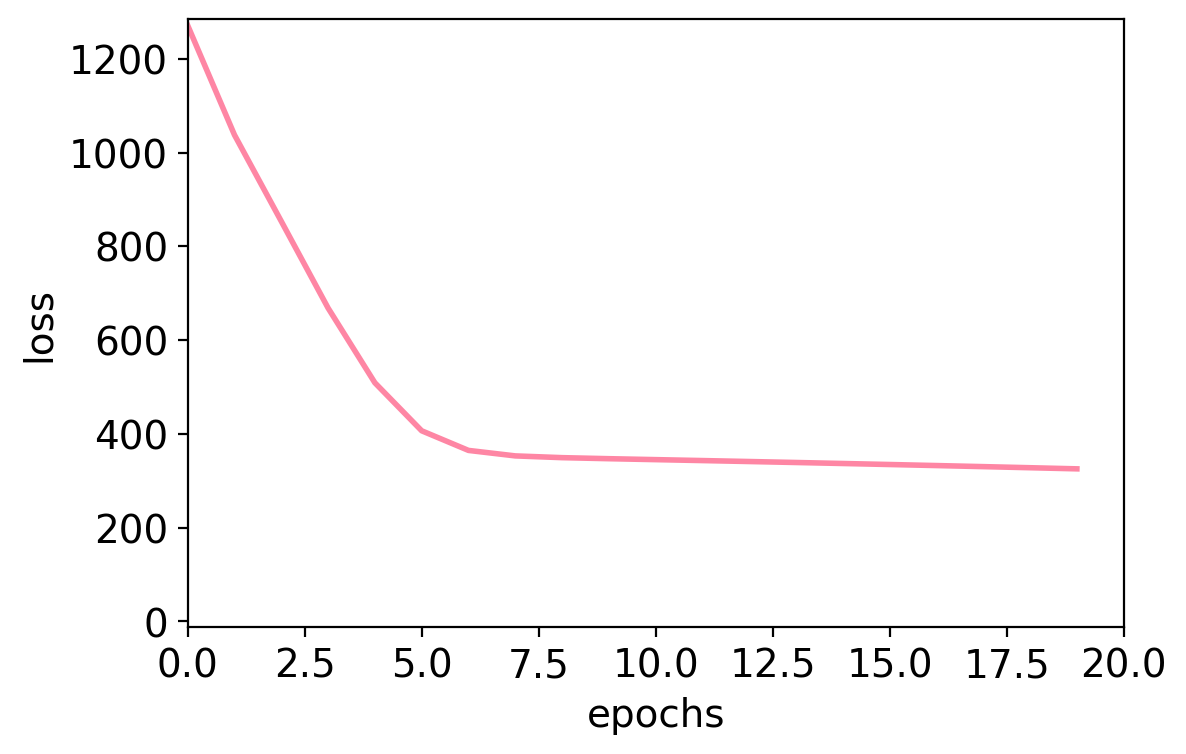

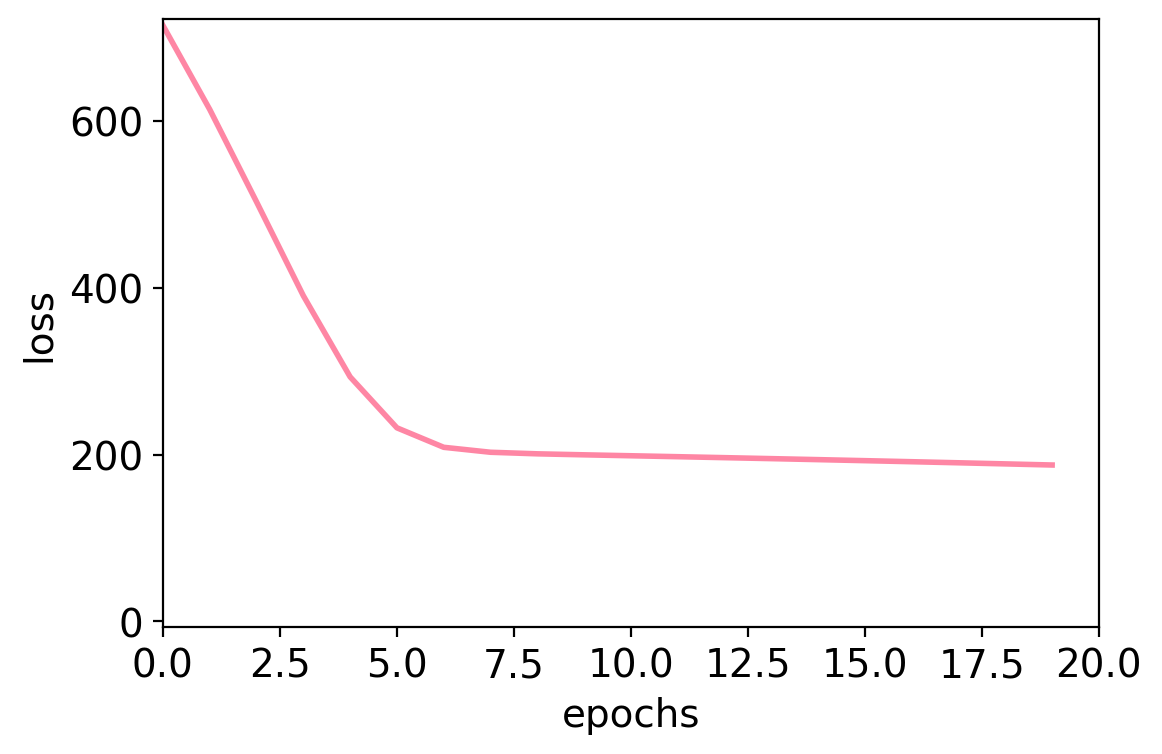

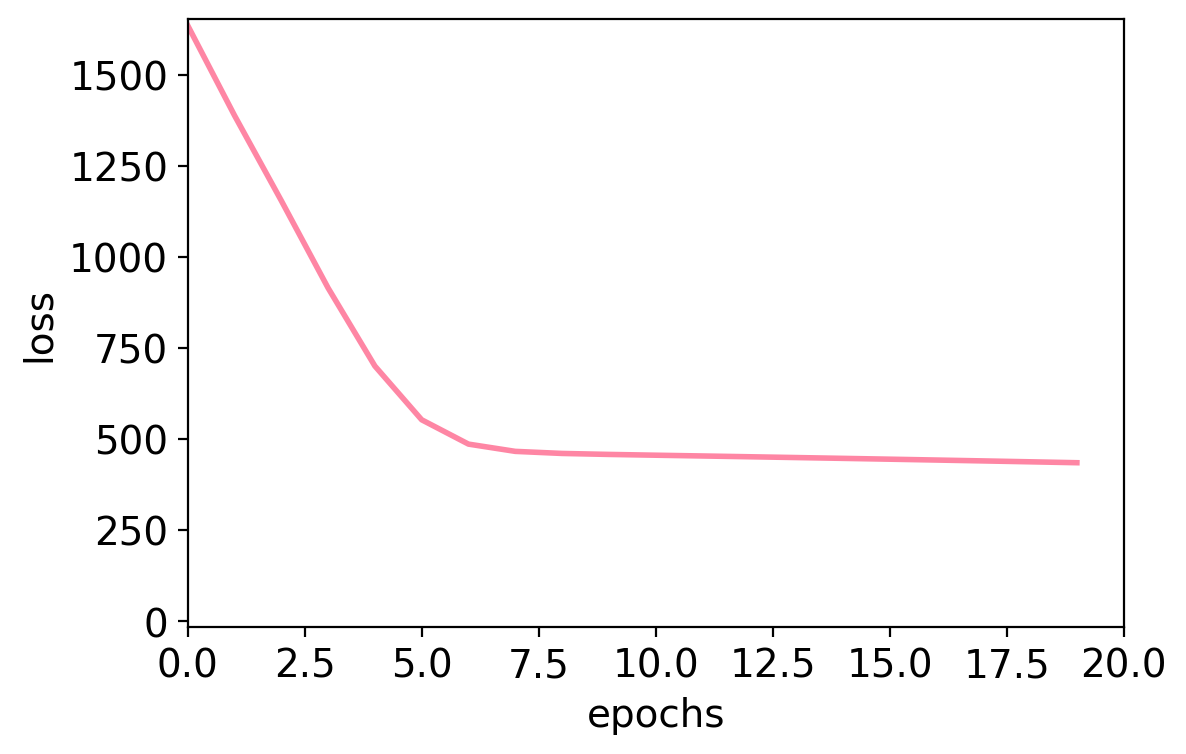

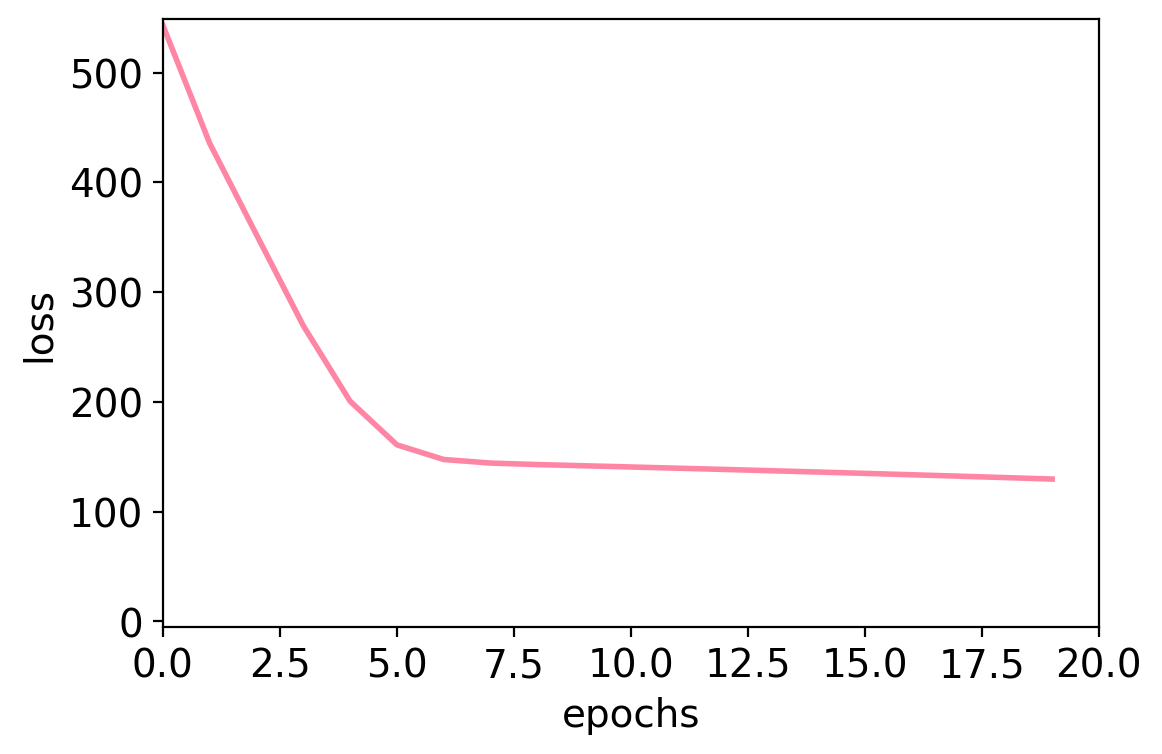

In [34]:
# create tracking variables
rho, pval = ss.spearmanr(diff_in_vs_out_p.loc[idxs], diff_tgfbr2ko_vs_wt.loc[idxs])
rhos, pvals = {'a5':rho}, {'a5':pval}
# perform the model perturbation for all areas
for name, avis_sub in avis_subs.items():
    if name == 'a5': continue
    print('Processing', name)
    ### TRAIN
    # retrieve positions from the data
    pos = torch.from_numpy(avis_sub.obsm['spatial'])
    edge_index = kneighbors_graph(pos, n_neighbors, include_self=False).todense()
    edge_index = torch.from_numpy(np.array(np.where(edge_index)))

    # instantiate the model, input and output will be the same
    model = simcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
    # now perform the simulation
    np.random.seed(seed)
    # convert the gene expression data to numpy
    x = torch.from_numpy(avis_sub.X)
    # sphere normalize the data (just in case)
    norm_factor = torch.sqrt(torch.pow(x, 2).sum(1)).reshape(-1,1)
    assert (norm_factor > 0).all()
    x = torch.div(x, norm_factor)
    # artifically set the g2g matrix
    model.set_g2g(model_rev.conv1.lin.weight.clone().detach())
    model.set_g2g_intra(model_rev.lin.weight.clone().detach())
    # initialize a gene expression matrix
    input_sphex = calc_sphex(x).clone().detach().numpy()
    model.set_sphex(torch.from_numpy(input_sphex.astype('float32')))
    
    # set up the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
    # keep track of the losses per data object
    loss, losses = None, []
    # train the model
    model.train()
    tmp_gexs = []
    # work through epochs
    for epoch in tqdm(range(epochs), total=epochs):
        # derive the message as well as the mean field approximation
        msg, msg_intra, log_z_mft = model(edge_index, 1)
        if (epoch % 5) == 0:
            tmp_gex = model.gex.clone().detach().numpy()
            tmp_gexs.append(tmp_gex)
        # compute the loss and track it
        loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
        losses.append(loss.detach().numpy()[0][0])
        # derive the gradients, update, and clear
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    ### LOSS
    # plot the loss
    fig, ax = plt.subplots(figsize=[6, 4])
    ax.grid(False)
    ax.plot(losses, lw=2, color='#fe86a4')
    ax.set_xlim(0, epochs)
    vmin, vmax = min(min(losses), 0), max(losses)
    vstep = (vmax - vmin) * 0.01
    ax.set_ylim(vmin-vstep, vmax+vstep)
    ax.set(xlabel='epochs', ylabel='loss')
    # retrieve the data
    output_gex = model.gex.detach().numpy()
    
    ### DIFFERENTIAL
    # add the layers
    for idx, tmp_gex in enumerate(tmp_gexs):
        avis_sub.layers[f'input{idx}'] = tmp_gex
    avis_sub.layers['output'] = output_gex
    
    # compute the differential within the area of interest vs outside
    avis_sub.layers['diff'] = avis_sub.layers['output'] - avis_sub.layers['input0']

a1
Perturbed 0.48250443206422666 2.221573226690986e-23
Random -0.028977279344117205 0.5748749625083207
a2
Perturbed 0.22477776971540728 1.0509493419597307e-05
Random -0.05213531882644135 0.31268216740609267


/loc/scratch/7949135/ipykernel_36721/3831419390.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Bin', y='Obs', data=df, saturation=1, linewidth=2,
/loc/scratch/7949135/ipykernel_36721/3831419390.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Bin', y='Obs', data=df, saturation=1, linewidth=2,


a3
Perturbed 0.4180309989187465 2.2281362199256594e-17
Random -0.05234964350885114 0.3106943529188993
a4
Perturbed 0.44491362961649095 9.994700338631487e-20
Random -0.036048650135223875 0.48527680657744077
a5
Perturbed 0.4841870039962483 1.4871585456734026e-23
Random -0.0691249730134543 0.18046986236921303


/loc/scratch/7949135/ipykernel_36721/3831419390.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Bin', y='Obs', data=df, saturation=1, linewidth=2,
/loc/scratch/7949135/ipykernel_36721/3831419390.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Bin', y='Obs', data=df, saturation=1, linewidth=2,
/loc/scratch/7949135/ipykernel_36721/3831419390.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Bin', y='Obs', data=df, saturation=1, linewidth=2,


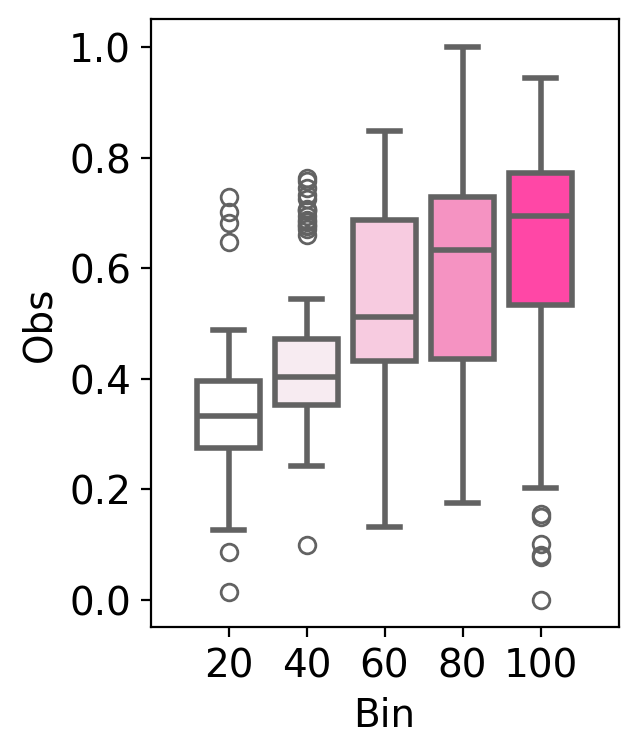

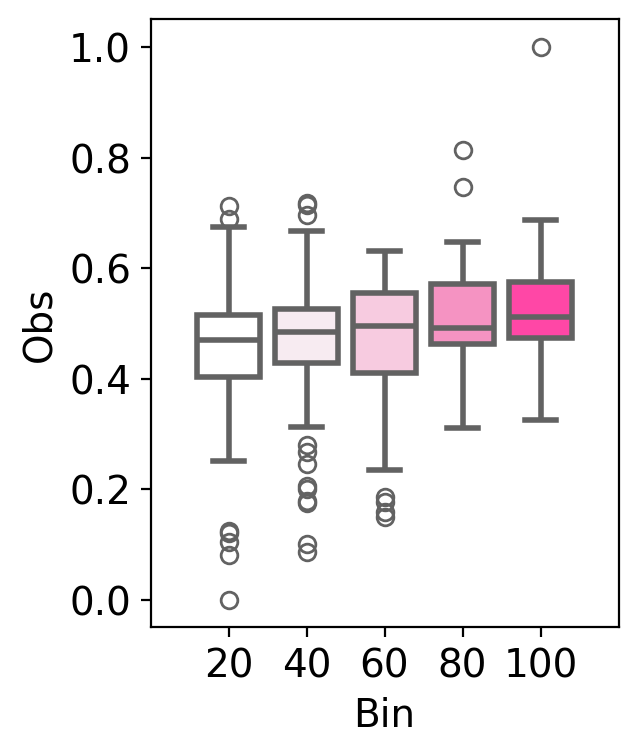

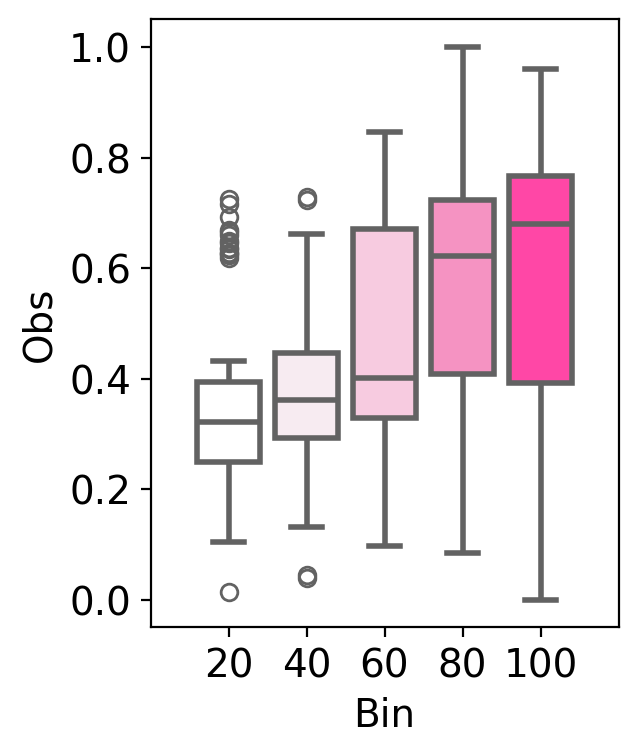

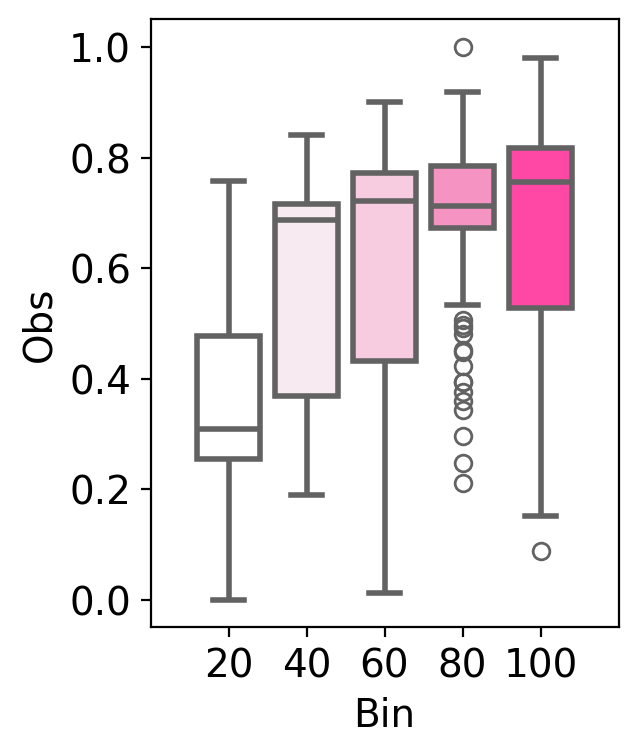

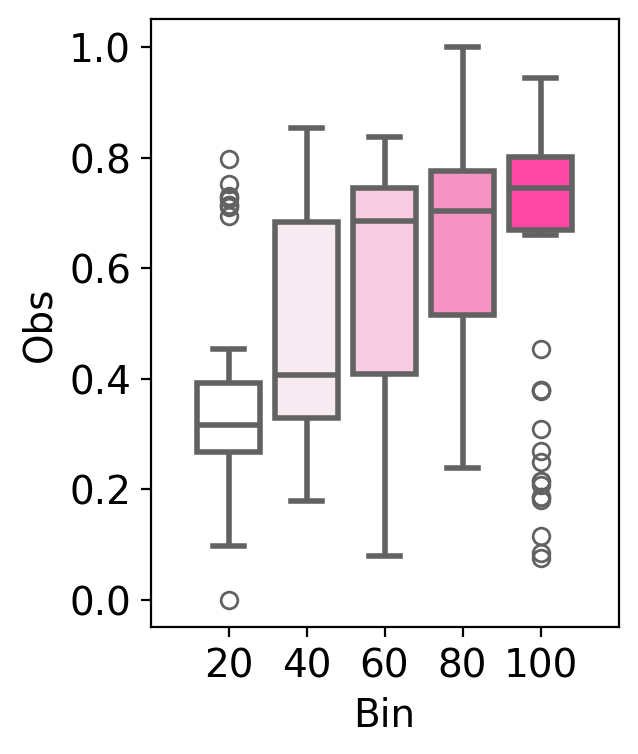

In [35]:
# plot as box plot
rand_rhos, rand_pvals = {}, {}
for name, avis_sub in avis_subs.items():
    np.random.seed(0)
    ### DIFFERENTIAL
    mask0 = avis_sub.obs['perturbed'] == 'unperturbed'
    mask1 = avis_sub.obs['perturbed'] == 'perturbed'
    diff_in_vs_out_p = pd.Series(avis_sub.layers['diff'][mask1].mean(0) - avis_sub.layers['diff'][mask0].mean(0),
                                 index=avis_sub.var_names).sort_values()[::-1]
    diff_in_vs_out_p -= diff_in_vs_out_p.min()
    diff_in_vs_out_p /= diff_in_vs_out_p.max()
    # remove the perturbed genes to get a clean look
    perturbed_genes = ['Tgfbr2']
    perturbed_label = 'Tgfbr2'
    diff_in_vs_out_p = diff_in_vs_out_p.loc[~diff_in_vs_out_p.index.isin(perturbed_genes)]

    ### CORRELATION
    # compute the correlation
    idxs = diff_in_vs_out_p.index.intersection(diff_tgfbr2ko_vs_wt.index)
    rho, pval = ss.spearmanr(diff_in_vs_out_p.loc[idxs], diff_tgfbr2ko_vs_wt.loc[idxs])
    rhos[name] = rho; pvals[name] = pval
    print(name)
    print('Perturbed', rho, pval)
    # perform random shuffling
    rho, pval = ss.spearmanr(np.random.choice(diff_in_vs_out_p.loc[idxs], size=len(idxs), replace=False),
                             np.random.choice(diff_tgfbr2ko_vs_wt.loc[idxs], size=len(idxs), replace=False))
    rand_rhos[name] = rho; rand_pvals[name] = pval
    print('Random', rho, pval)
    
    ### PLOTTING
    # setup the dataframe
    idxs = diff_in_vs_out_p.index.intersection(diff_tgfbr2ko_vs_wt.index)
    df = pd.concat([diff_in_vs_out_p.loc[idxs], diff_tgfbr2ko_vs_wt.loc[idxs]], axis=1)
    df.columns = ['Obs','Exp']
    df['Bin'] = np.nan
    # derive the bins
    vmin = min(diff_tgfbr2ko_vs_wt.loc[idxs])
    step_size = 20
    for step in range(100//step_size):
        vmax = np.percentile(df['Exp'], (step+1)*step_size)
        mask = (df['Exp'] >= vmin) & (df['Exp'] < vmax)
        vmin = vmax
        genes = df['Exp'].index[mask]
        df.loc[genes, 'Bin'] = str(int((step+1)*step_size))
    # plot the bars
    fig, ax = plt.subplots(figsize=[3, 4])
    ax.grid(False)
    sns.boxplot(x='Bin', y='Obs', data=df, saturation=1, linewidth=2,
                order=['20','40','60','80','100'], palette=['#ff47a6','#f593c2','#f7cbe0','#f7ebf1','#ffffff'][::-1])
    ax.set_xlim(-1, 5)

MannwhitneyuResult(statistic=25.0, pvalue=0.007936507936507936)


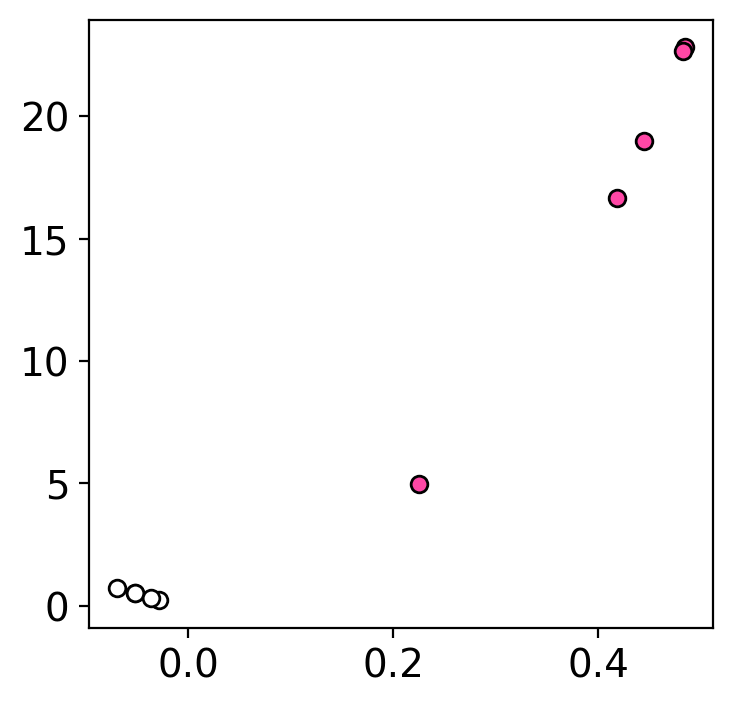

In [36]:
# examine them all together
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
ax.scatter(list(rand_rhos.values()), -np.log10(list(rand_pvals.values())), edgecolor='k', color='white')
ax.scatter(list(rhos.values()), -np.log10(list(pvals.values())), edgecolor='k', color='#ff47a6')
# report the statistics
print(ss.mannwhitneyu(list(rhos.values()), list(rand_rhos.values())))